In [ ]:
import glob

from potoo.plot import *
from potoo.util import *
import sklearn

from cache import *
from constants import *
from datasets import *
from features import *
from load import *
from sp14.model import *
from util import *
from viz import *

figsize('inline_short');

In [ ]:
recs_paths = load_recs_paths([
    'peterson-field-guide',
    'recordings',
])
display(
    df_summary(recs_paths),
    recs_paths[:5],
)

,dataset,path
dtype,object,object
sizeof,46.7 KiB,72.2 KiB
len,633,633
count,633,633
nunique,2,633
mean,NaN,NaN
std,NaN,NaN
min,peterson-field-guide,peterson-field-guide/amecro/audio/43215281 Caw (clear).mp3
25%,peterson-field-guide,peterson-field-guide/canwre/audio/43219271 Male Song (unusual).mp3
50%,peterson-field-guide,peterson-field-guide/marwre/audio/44412311 Chit.mp3


,dataset,path
0,recordings,recordings/081845.wav
1,recordings,"recordings/ACWO,NOFL,SPTO spotted towhee, acorn woodpecker, flicker.wav"
2,recordings,recordings/BEWR Bewicks Wren (Coyote Hills parking lot).wav
3,recordings,recordings/BEWR Bewicks Wren 2 (Coyote Hills parking lot) 2.wav
4,recordings,recordings/BEWR Bewicks Wren 2 (Coyote Hills parking lot).wav


In [ ]:
recs = load_recs_data(recs_paths)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.2s

[                                                                                          ] | 0% Completed |  0.3s

[                                                                                          ] | 0% Completed |  0.4s

[                                                                                          ] | 0% Completed |  0.5s

[                                                                                          ] | 0% Completed |  0.6s

[                                                                                          ] | 0% Completed |  0.7s

[                                                                                          ] | 0% Completed |  0.9s

[#                                                                                         ] | 1% Completed |  1.0s

[#                                                                                         ] | 1% Completed |  1.2s

[##                                                                                        ] | 2% Completed |  1.3s

[##                                                                                        ] | 2% Completed |  1.4s

[##                                                                                        ] | 2% Completed |  1.5s

[##                                                                                        ] | 2% Completed |  1.7s

[##                                                                                        ] | 2% Completed |  1.8s

[##                                                                                        ] | 2% Completed |  1.9s

[##                                                                                        ] | 3% Completed |  2.0s

[##                                                                                        ] | 3% Completed |  2.2s

[###                                                                                       ] | 3% Completed |  2.3s

[###                                                                                       ] | 3% Completed |  2.4s

[###                                                                                       ] | 3% Completed |  2.5s

[###                                                                                       ] | 4% Completed |  2.6s

[####                                                                                      ] | 5% Completed |  2.7s

[#####                                                                                     ] | 5% Completed |  2.8s

[#####                                                                                     ] | 6% Completed |  3.0s

[#####                                                                                     ] | 6% Completed |  3.1s

[#####                                                                                     ] | 6% Completed |  3.2s

[#####                                                                                     ] | 6% Completed |  3.4s

[#####                                                                                     ] | 6% Completed |  3.5s

[#####                                                                                     ] | 6% Completed |  3.7s

[#####                                                                                     ] | 6% Completed |  3.8s

[#####                                                                                     ] | 6% Completed |  4.0s

[######                                                                                    ] | 7% Completed |  4.1s

[######                                                                                    ] | 7% Completed |  4.3s

[#######                                                                                   ] | 8% Completed |  4.5s

[#######                                                                                   ] | 8% Completed |  4.6s

[#######                                                                                   ] | 8% Completed |  4.8s

[########                                                                                  ] | 8% Completed |  4.9s

[########                                                                                  ] | 9% Completed |  5.1s

[########                                                                                  ] | 9% Completed |  5.2s

[########                                                                                  ] | 9% Completed |  5.3s

[#########                                                                                 ] | 10% Completed |  5.6s

[##########                                                                                ] | 11% Completed |  5.7s

[##########                                                                                ] | 11% Completed |  5.9s

[###########                                                                               ] | 12% Completed |  6.0s

[###########                                                                               ] | 12% Completed |  6.1s

[###########                                                                               ] | 12% Completed |  6.2s

[###########                                                                               ] | 13% Completed |  6.4s

[###########                                                                               ] | 13% Completed |  6.5s

[############                                                                              ] | 13% Completed |  6.8s

[#############                                                                             ] | 14% Completed |  6.9s

[##############                                                                            ] | 16% Completed |  7.0s

[##############                                                                            ] | 16% Completed |  7.1s

[################                                                                          ] | 18% Completed |  7.2s

[##################                                                                        ] | 20% Completed |  7.4s

[####################                                                                      ] | 23% Completed |  7.5s

[######################                                                                    ] | 25% Completed |  7.6s

[#########################                                                                 ] | 28% Completed |  7.7s

[###########################                                                               ] | 30% Completed |  7.8s

[##############################                                                            ] | 33% Completed |  7.9s

[#################################                                                         ] | 36% Completed |  8.0s

[###################################                                                       ] | 39% Completed |  8.1s

[#####################################                                                     ] | 41% Completed |  8.2s

[########################################                                                  ] | 44% Completed |  8.3s

[##########################################                                                ] | 47% Completed |  8.4s

[#############################################                                             ] | 50% Completed |  8.6s

[###############################################                                           ] | 52% Completed |  8.7s

[################################################                                          ] | 53% Completed |  8.8s

[#################################################                                         ] | 55% Completed |  8.9s

[###################################################                                       ] | 57% Completed |  9.0s

[#####################################################                                     ] | 59% Completed |  9.1s

[#######################################################                                   ] | 61% Completed |  9.2s

[#########################################################                                 ] | 64% Completed |  9.3s

[###########################################################                               ] | 66% Completed |  9.5s

[#############################################################                             ] | 68% Completed |  9.6s

[##############################################################                            ] | 69% Completed |  9.7s

[################################################################                          ] | 72% Completed |  9.8s

[###################################################################                       ] | 75% Completed |  9.9s

[#####################################################################                     ] | 76% Completed | 10.0s

[#######################################################################                   ] | 79% Completed | 10.1s

[#########################################################################                 ] | 82% Completed | 10.2s

[###########################################################################               ] | 84% Completed | 10.3s

[##############################################################################            ] | 86% Completed | 10.4s

[################################################################################          ] | 89% Completed | 10.5s

[##################################################################################        ] | 91% Completed | 10.7s

[###################################################################################       ] | 92% Completed | 10.8s

[######################################################################################    ] | 95% Completed | 10.9s

[#######################################################################################   ] | 97% Completed | 11.0s

[##########################################################################################] | 100% Completed | 11.1s

In [ ]:
display(
    df_summary(recs),
    recs[:5],
)

,dataset,species,species_longhand,species_com_name,species_query,basename,name,duration_s,samples_mb,samples_n,audio
dtype,object,category,category,category,object,object,object,float64,float64,int64,object
sizeof,51.6 KiB,42.7 KiB,53.2 KiB,48.9 KiB,43.8 KiB,55.7 KiB,74.6 KiB,24.8 KiB,24.8 KiB,27.2 KiB,29.7 KiB
len,633,633,633,633,633,633,633,633,633,633,633
count,633,633,633,633,633,633,633,633,633,633,633
nunique,2.0,55.0,55.0,55.0,64.0,633.0,633.0,537.0,537.0,537.0,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.841,1.213,635941.850,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.301,1.358,712235.547,NaN
min,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,BEWR,081845,peterson-field-guide/amecro/audio/43215281 Caw (clear),2.74,0.115,60480,NaN
25%,peterson-field-guide,TUTI,Tufted Titmouse - TUTI,Tufted Titmouse,bewwre,43217721 Chick-a-dee Call,peterson-field-guide/canwre/audio/43219271 Male Song (unusual),15.50,0.650,340992,NaN
50%,peterson-field-guide,WIWR,Winter Wren - WIWR,Winter Wren,comrav,43219841 Churt,peterson-field-guide/marwre/audio/44412311 Chit,21.40,0.901,472320,NaN


,dataset,species,species_longhand,species_com_name,species_query,basename,name,duration_s,samples_mb,samples_n,audio
479,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186591 Kuk-curr Series,peterson-field-guide/scaqua/audio/43186591 Kuk-curr Series,12.30,0.517,271296,"peterson-field-guide/scaqua/audio/43186591 Kuk-curr Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 12.304s long"
485,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186661 Chip-seer,peterson-field-guide/scaqua/audio/43186661 Chip-seer,12.10,0.509,266688,"peterson-field-guide/scaqua/audio/43186661 Chip-seer: 1 channels, 16 bit, sampled @ 22.05 kHz, 12.095s long"
486,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186671 Kuk,peterson-field-guide/scaqua/audio/43186671 Kuk,15.60,0.657,344448,"peterson-field-guide/scaqua/audio/43186671 Kuk: 1 channels, 16 bit, sampled @ 22.05 kHz, 15.621s long"
487,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186681 Wing sounds & Kuk,peterson-field-guide/scaqua/audio/43186681 Wing sounds & Kuk,7.73,0.325,170496,"peterson-field-guide/scaqua/audio/43186681 Wing sounds & Kuk: 1 channels, 16 bit, sampled @ 22.05 kHz, 7.732s long"
482,peterson-field-guide,SCQU,Scaled Quail - SCQU,Scaled Quail,scaqua,43186621 Zreek Series,peterson-field-guide/scaqua/audio/43186621 Zreek Series,10.10,0.423,221760,"peterson-field-guide/scaqua/audio/43186621 Zreek Series: 1 channels, 16 bit, sampled @ 22.05 kHz, 10.057s long"


In [ ]:
# Stats
(recs
    .assign(
        n=1,
        duration_h=lambda df: df.duration_s / 3600,
        samples_gb=lambda df: df.samples_mb / 1024,
        species=lambda df: df.species.cat.remove_unused_categories(),  # Else groupby includes all categories
    )
    .groupby([
        'dataset',
        'species',
    ])
    [['n', 'duration_h', 'samples_gb', 'samples_n']]
    .sum()
    .dropna()
)

n  duration_h  samples_gb  samples_n
dataset              species                                         
peterson-field-guide SCQU     11.0       0.052   7.749e-03  4.160e+06
                     MONQ      9.0       0.052   7.715e-03  4.142e+06
                     WITU     13.0       0.087   1.289e-02  6.920e+06
                     OSPR      7.0       0.038   5.593e-03  3.003e+06
                     KILL     10.0       0.052   7.715e-03  4.142e+06
                     BEKI      7.0       0.036   5.353e-03  2.874e+06
                     AMCR     17.0       0.103   1.526e-02  8.194e+06
                     CORA     17.0       0.107   1.581e-02  8.486e+06
                     CACH     18.0       0.092   1.366e-02  7.336e+06
                     BCCH     19.0       0.082   1.215e-02  6.526e+06
                     BOCH     12.0       0.065   9.655e-03  5.183e+06
                     TUTI     26.0       0.144   2.124e-02  1.140e+07
                     BCTI     20.0       0.119   1.765e-02  9.476e+06
                     BUSH     12.0       0.050   7.447e-03  3.998e+06
                     RBNU     16.0       0.102   1.508e-02  8.095e+06
                     WBNU     17.0       0.082   1.213e-02  6.513e+06
                     BRCR     17.0       0.083   1.226e-02  6.583e+06
                     ROWR     13.0       0.086   1.264e-02  6.788e+06
                     CANW     15.0       0.068   1.011e-02  5.428e+06
                     HOWR     20.0       0.126   1.866e-02  1.002e+07
                     WIWR      9.0       0.091   1.342e-02  7.205e+06
                     SEWR     11.0       0.079   1.169e-02  6.275e+06
                     MAWR     20.0       0.141   2.087e-02  1.120e+07
                     CARW     19.0       0.098   1.447e-02  7.767e+06
                     BEWR     19.0       0.114   1.688e-02  9.060e+06
                     CACW     14.0       0.068   1.000e-02  5.369e+06
                     SWTH     15.0       0.091   1.349e-02  7.240e+06
                     HETH     18.0       0.119   1.756e-02  9.430e+06
                     AMRO     19.0       0.103   1.527e-02  8.199e+06
                     EUST     18.0       0.115   1.704e-02  9.147e+06
                     CEDW      7.0       0.036   5.373e-03  2.885e+06
                     OCWA     16.0       0.096   1.417e-02  7.610e+06
                     WIWA     15.0       0.092   1.358e-02  7.293e+06
                     WCSP     20.0       0.089   1.311e-02  7.036e+06
                     SOSP     19.0       0.094   1.389e-02  7.460e+06
recordings           OSPR      1.0       0.025   3.682e-03  1.977e+06
                     RTHA      4.0       0.047   6.977e-03  3.746e+06
                     HAWO      2.0       0.032   4.754e-03  2.552e+06
                     PSFL      1.0       0.015   2.209e-03  1.186e+06
                     BLPH      2.0       0.032   4.771e-03  2.561e+06
                     HUVI      1.0       0.024   3.622e-03  1.944e+06
                     STJA      1.0       0.019   2.822e-03  1.515e+06
                     CASJ      2.0       0.070   1.029e-02  5.525e+06
                     CORA      2.0       0.029   4.257e-03  2.285e+06
                     RBNU      1.0       0.037   5.508e-03  2.957e+06
                     BRCR      1.0       0.009   1.282e-03  6.884e+05
                     MAWR      1.0       0.006   9.482e-04  5.091e+05
                     BEWR      3.0       0.030   4.400e-03  2.362e+06
                     GRCA      1.0       0.019   2.819e-03  1.514e+06
                     CATH      2.0       0.034   5.026e-03  2.698e+06
                     NOMO      1.0       0.017   2.544e-03  1.366e+06
                     BTYW      1.0       0.017   2.443e-03  1.312e+06
                     HEWA      1.0       0.097   1.435e-02  7.703e+06
                     WIWA      2.0       0.022   3.217e-03  1.727e+06
                     FOSP      1.0       0.032   4.674e-03  2.509e+06
                     WCSP      2.0       0.

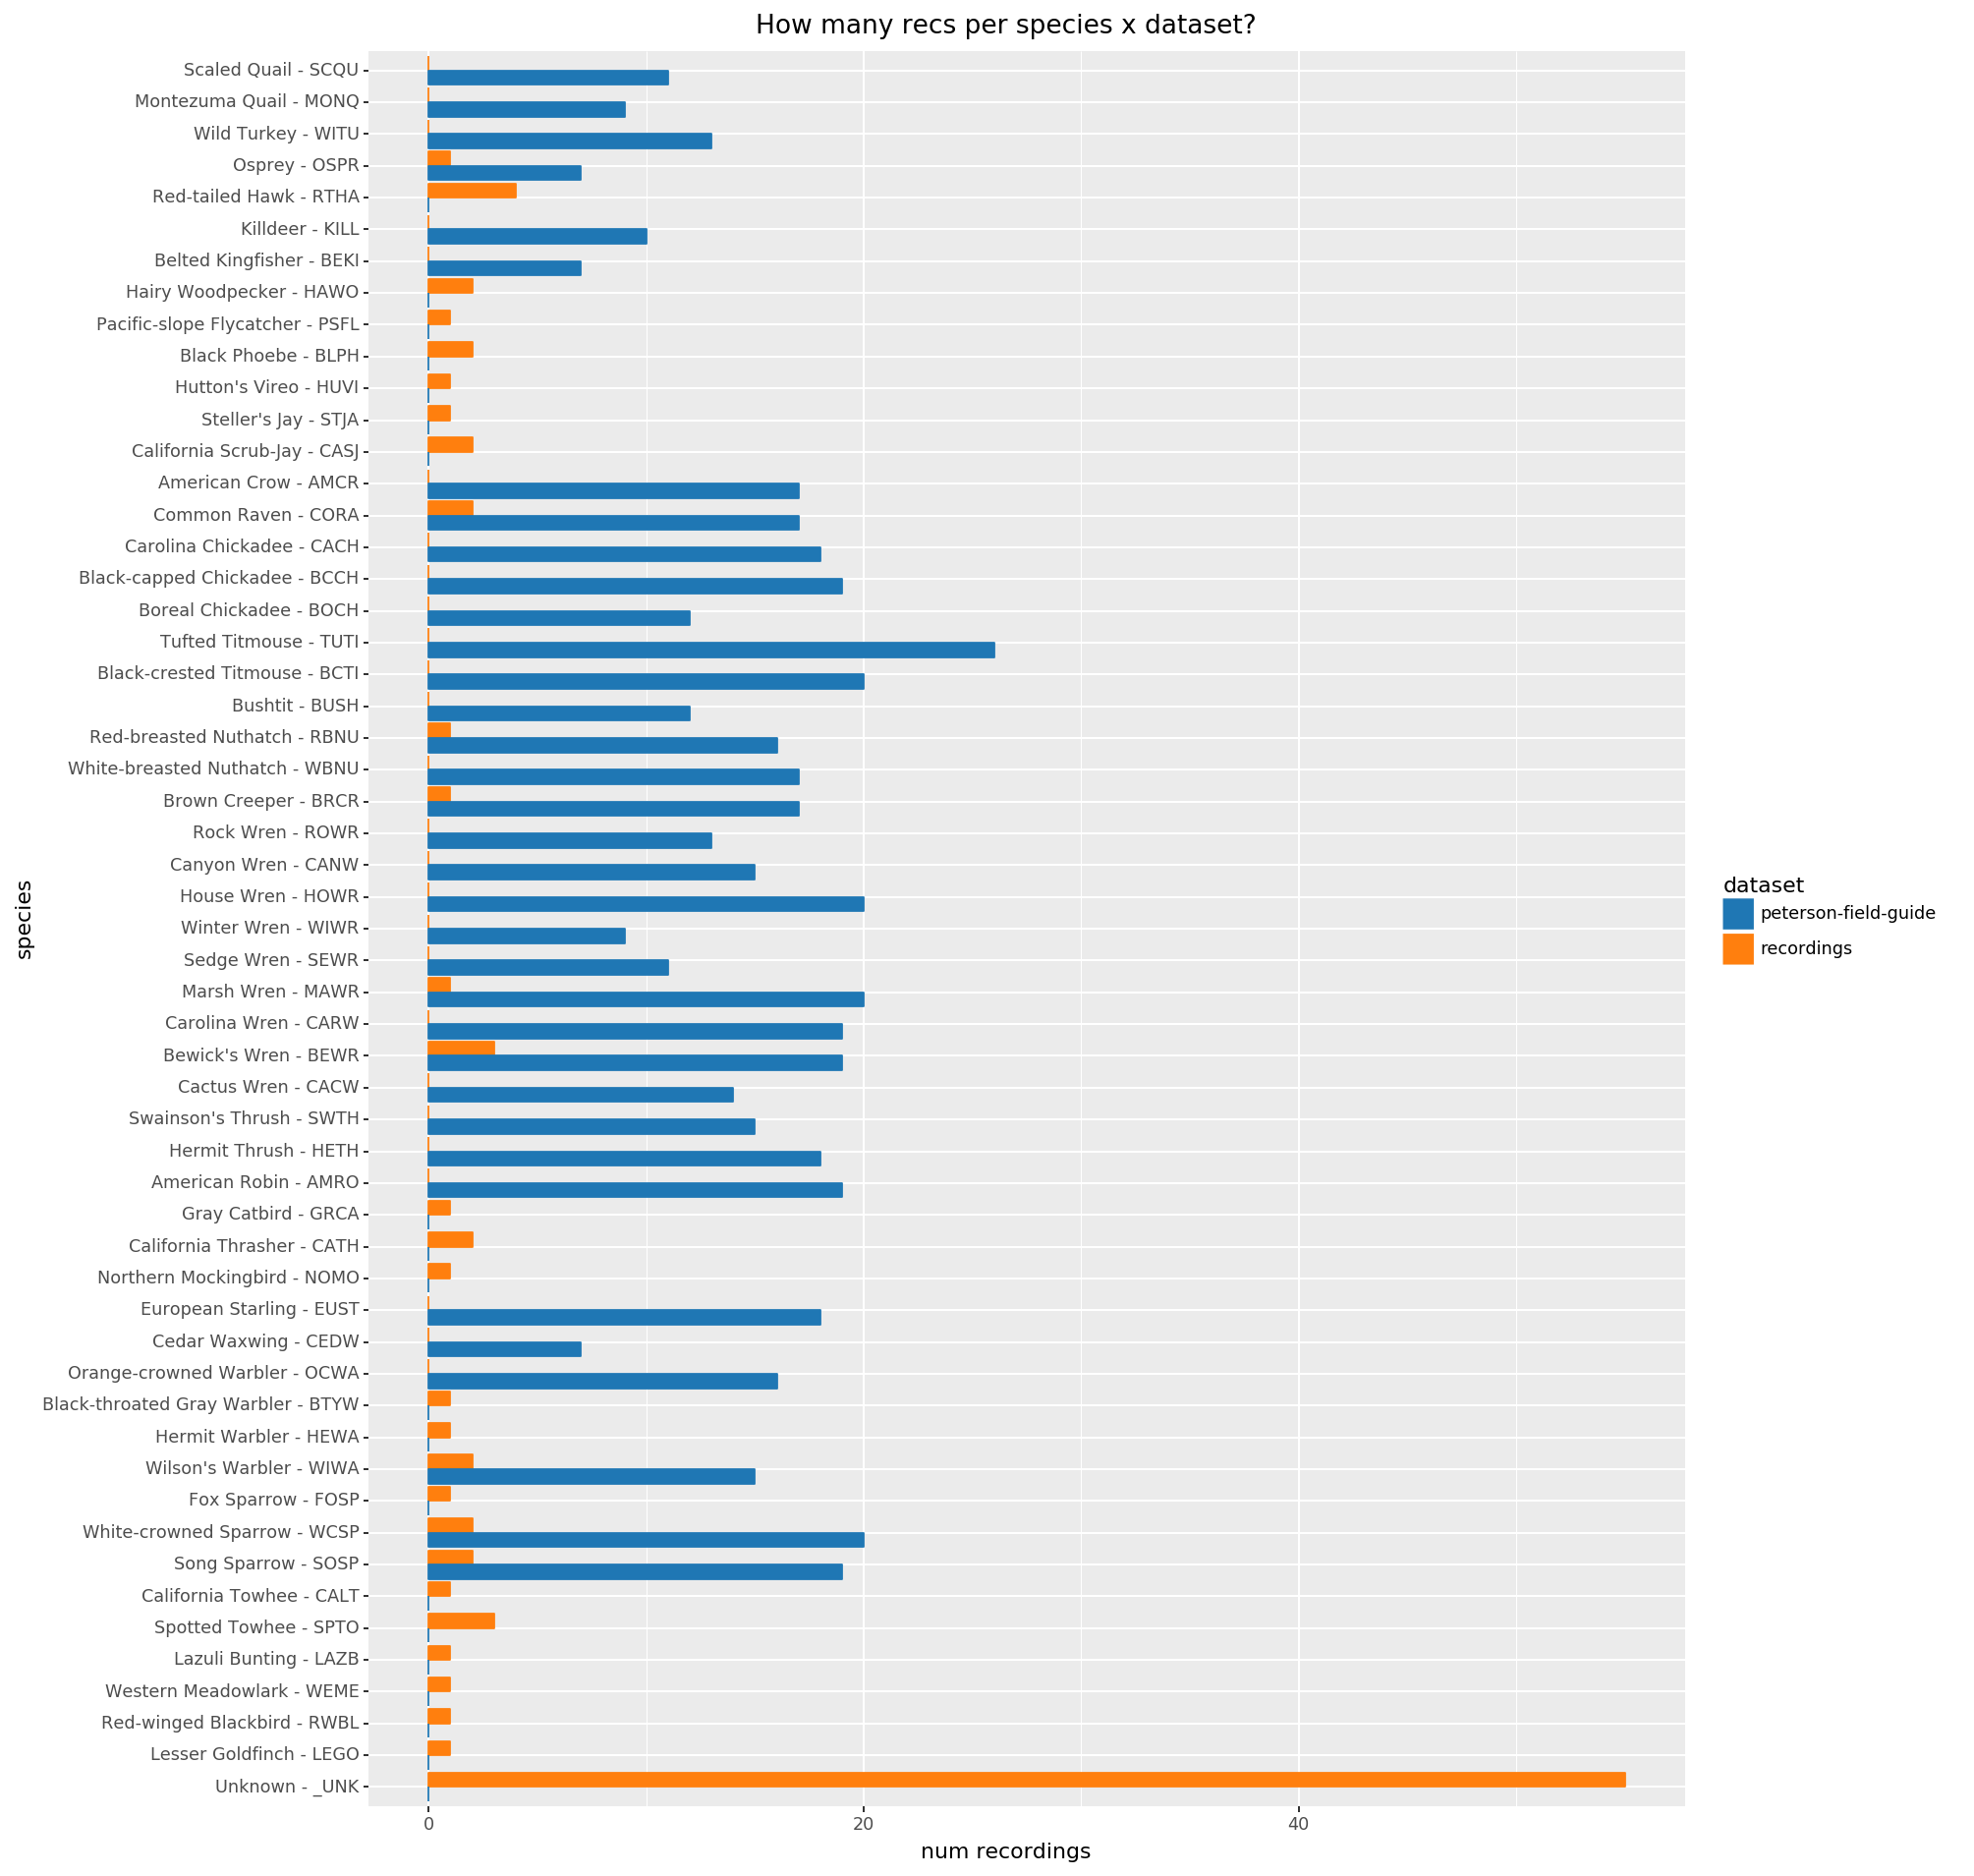

<ggplot: (-9223372036131288828)>

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(n=1)
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, n=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])['n'].sum().reset_index()
    .pipe(df_reverse_cat, 'species')
    .pipe(ggplot, aes(x='species', y='n', color='dataset', fill='dataset'))
    + coord_flip()
    + stat_identity(geom='bar', position=position_dodge())
    + ylab('num recordings')
    + scale_color_cmap_d(mpl.cm.tab10)
    + scale_fill_cmap_d(mpl.cm.tab10)
    + theme_figsize('half')
    + ggtitle('How many recs per species x dataset?')
)

In [ ]:
%%time
# Basic features
from sp14.model import *
features = Features()
recs['spectro'] = features.spectros(recs)
recs['patches'] = features.patches(recs)

[Memory]23.0s, 0.4min   : Loading _spectros_cache_block from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_spectros_cache_block/12fe89a60f89cdf0e5ac6a449ed4bc31


________________________________spectros_cache_block cache loaded - 3.8s, 0.1min


[Memory]27.9s, 0.5min   : Loading _spectros_cache_block from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_spectros_cache_block/46078628328e875092e1833fbb91829a


________________________________spectros_cache_block cache loaded - 1.8s, 0.0min
[21:40:29.037] Features.patches:recs
  len(recs): 633
  sum(duration_h): 5.07
  sum(samples_mb): 768.0
  sum(samples_n): 402551191


[Memory]38.1s, 0.6min   : Loading _patches_from_spectros from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_patches_from_spectros/96af7b9231295ba11118ee26ea24f638


_______________________________patches_from_spectros cache loaded - 1.9s, 0.0min
[21:40:39.219] Features.patches:patches
  (f*p, sum(t)): [160, 1569676]
CPU times: user 10.2 s, sys: 6.07 s, total: 16.2 s
Wall time: 18.2 s


In [ ]:
%%time
# Fit projection, add learned features
from sp14.model import *

# k, n = 50,  60   # Faster dev
k, n = 500, 300  # Mem safe (~17m uncached for 6 configs)
# k, n = 500, 535  # Full [XXX Not mem safe] [len(peterson) is currently 535]
recs_train_projection = (recs
    [lambda df: df.dataset == 'peterson-field-guide']
    .pipe(sklearn.utils.shuffle, random_state=0)
    .sample(n, random_state=0)
)

projection = Projection(k=k)
projection.fit(recs_train_projection)
recs['feat'] = projection.transform(recs)

[21:40:46.394] Projection.fit:patches
  patches dims: [300, 160, 531092]


[Memory]48.2s, 0.8min   : Loading _fit from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_fit/615ae96acb1738bec487dded73797928
_________________________________________________fit cache loaded - 0.0s, 0.0min
[21:40:47.450] Projection.fit:skm.fit
  skm.pca.components_.shape: [106, 160]
  skm.D.shape: [106, 500]


[21:40:48.676] [SKM] transform
[21:40:48.676] [SKM] _pca_transform


CPU times: user 24.2 s, sys: 29.7 s, total: 53.9 s
Wall time: 39.1 s


In [ ]:
%%time
# Fit search
from sp14.model import *

recs_eval = (recs
    [lambda df: df.dataset == 'peterson-field-guide']
    # [:10]  # Faster dev
    .reset_index(drop=True)
)
train_n, test_n = (len(recs_eval)+1)//2, len(recs_eval)//2
recs_train, recs_test = (recs_eval
    .pipe(sklearn.utils.shuffle, random_state=0)
    .sample(train_n + test_n, random_state=0)
    .pipe(lambda df: (
        df[:train_n],
        df[train_n : train_n + test_n],
    ))
)
log('params', **{
    'recs_eval': len(recs_eval),
    'recs_train': len(recs_train),
    'recs_test': len(recs_test),
})

search = Search(
    # n_neighbors=3,
    n_neighbors=5,
    # n_neighbors=10,
)
search.fit(recs_train)

[21:41:26.206] params
  recs_eval: 535
  recs_train: 268
  recs_test: 267
[21:41:26.266] Search.fit:feats
  recs: 268
  (n, f*p): [268, 1500]
[Memory]87.0s, 1.5min   : Loading _fit from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_fit/de69438357e567001b5d625f57c190bd
_________________________________________________fit cache loaded - 0.0s, 0.0min
[21:41:26.289] Search.fit:knn
  knn.get_params: {algorithm: auto, leaf_size: 30, metric: minkowski, metric_params: null, n_jobs: 1, n_neighbors: 5, p: 2, weights: uniform}
  knn.classes_: [SCQU, MONQ, WITU, OSPR, KILL, BEKI, AMCR, CORA, CACH, BCCH, BOCH, TUTI, BCTI, BUSH, RBNU, WBNU, BRCR, CACW, ROWR, CANW, CARW, BEWR, HOWR, WIWR, SEWR, MAWR, SWTH, HETH, AMRO, EUST, CEDW, OCWA, WIWA, SOSP, WCSP]
  knn.classes_.len: 35
CPU times: user 77.8 ms, sys: 10 ms, total: 87.8 ms
Wall time: 93.3 ms


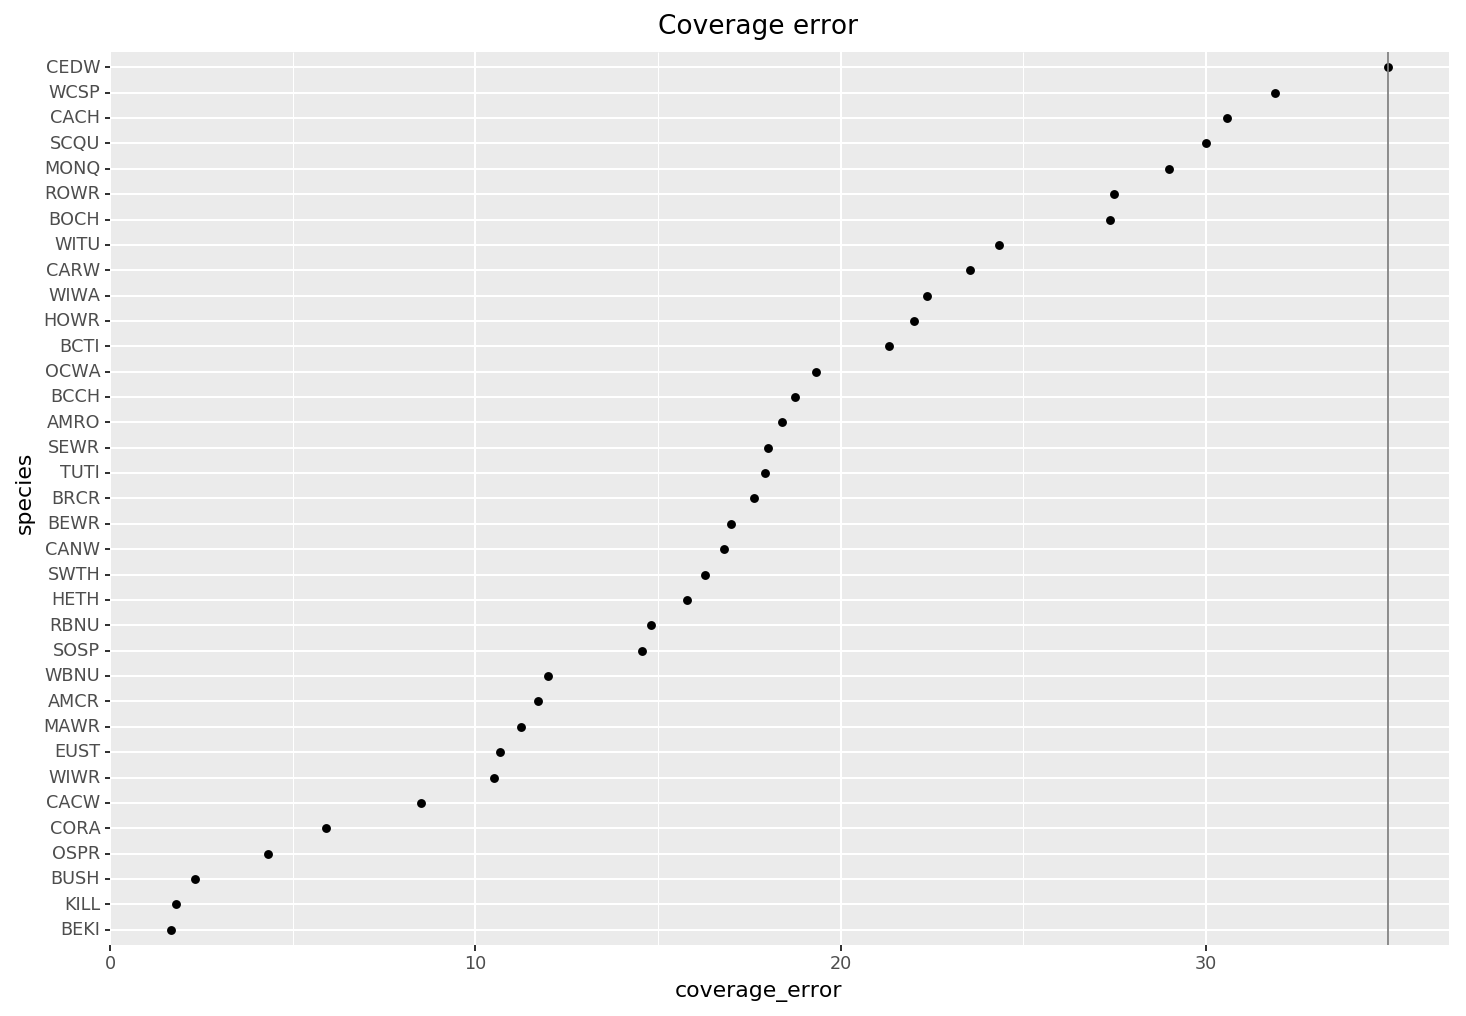

<ggplot: (-9223372036545762388)>

In [ ]:
(search.coverage_error(recs_test, by='species')
    .pipe(lambda df: df_transform_cat(df, lambda _: df.sort_values('coverage_error').species, 'species'))
    .pipe(ggplot, aes(x='species', y='coverage_error'))
    + geom_point()
    + coord_flip()
    + geom_hline(yintercept=len(set(search.fit_classes_)), color='grey')
    + theme_figsize('inline')
    + ggtitle('Coverage error')
)

[21:41:28.416] Search.species
  recs: 267
  (n, k*a): [267, 1500]
  species: 267
[21:41:28.421] Search.confusion_matrix
  M: [35, 35]


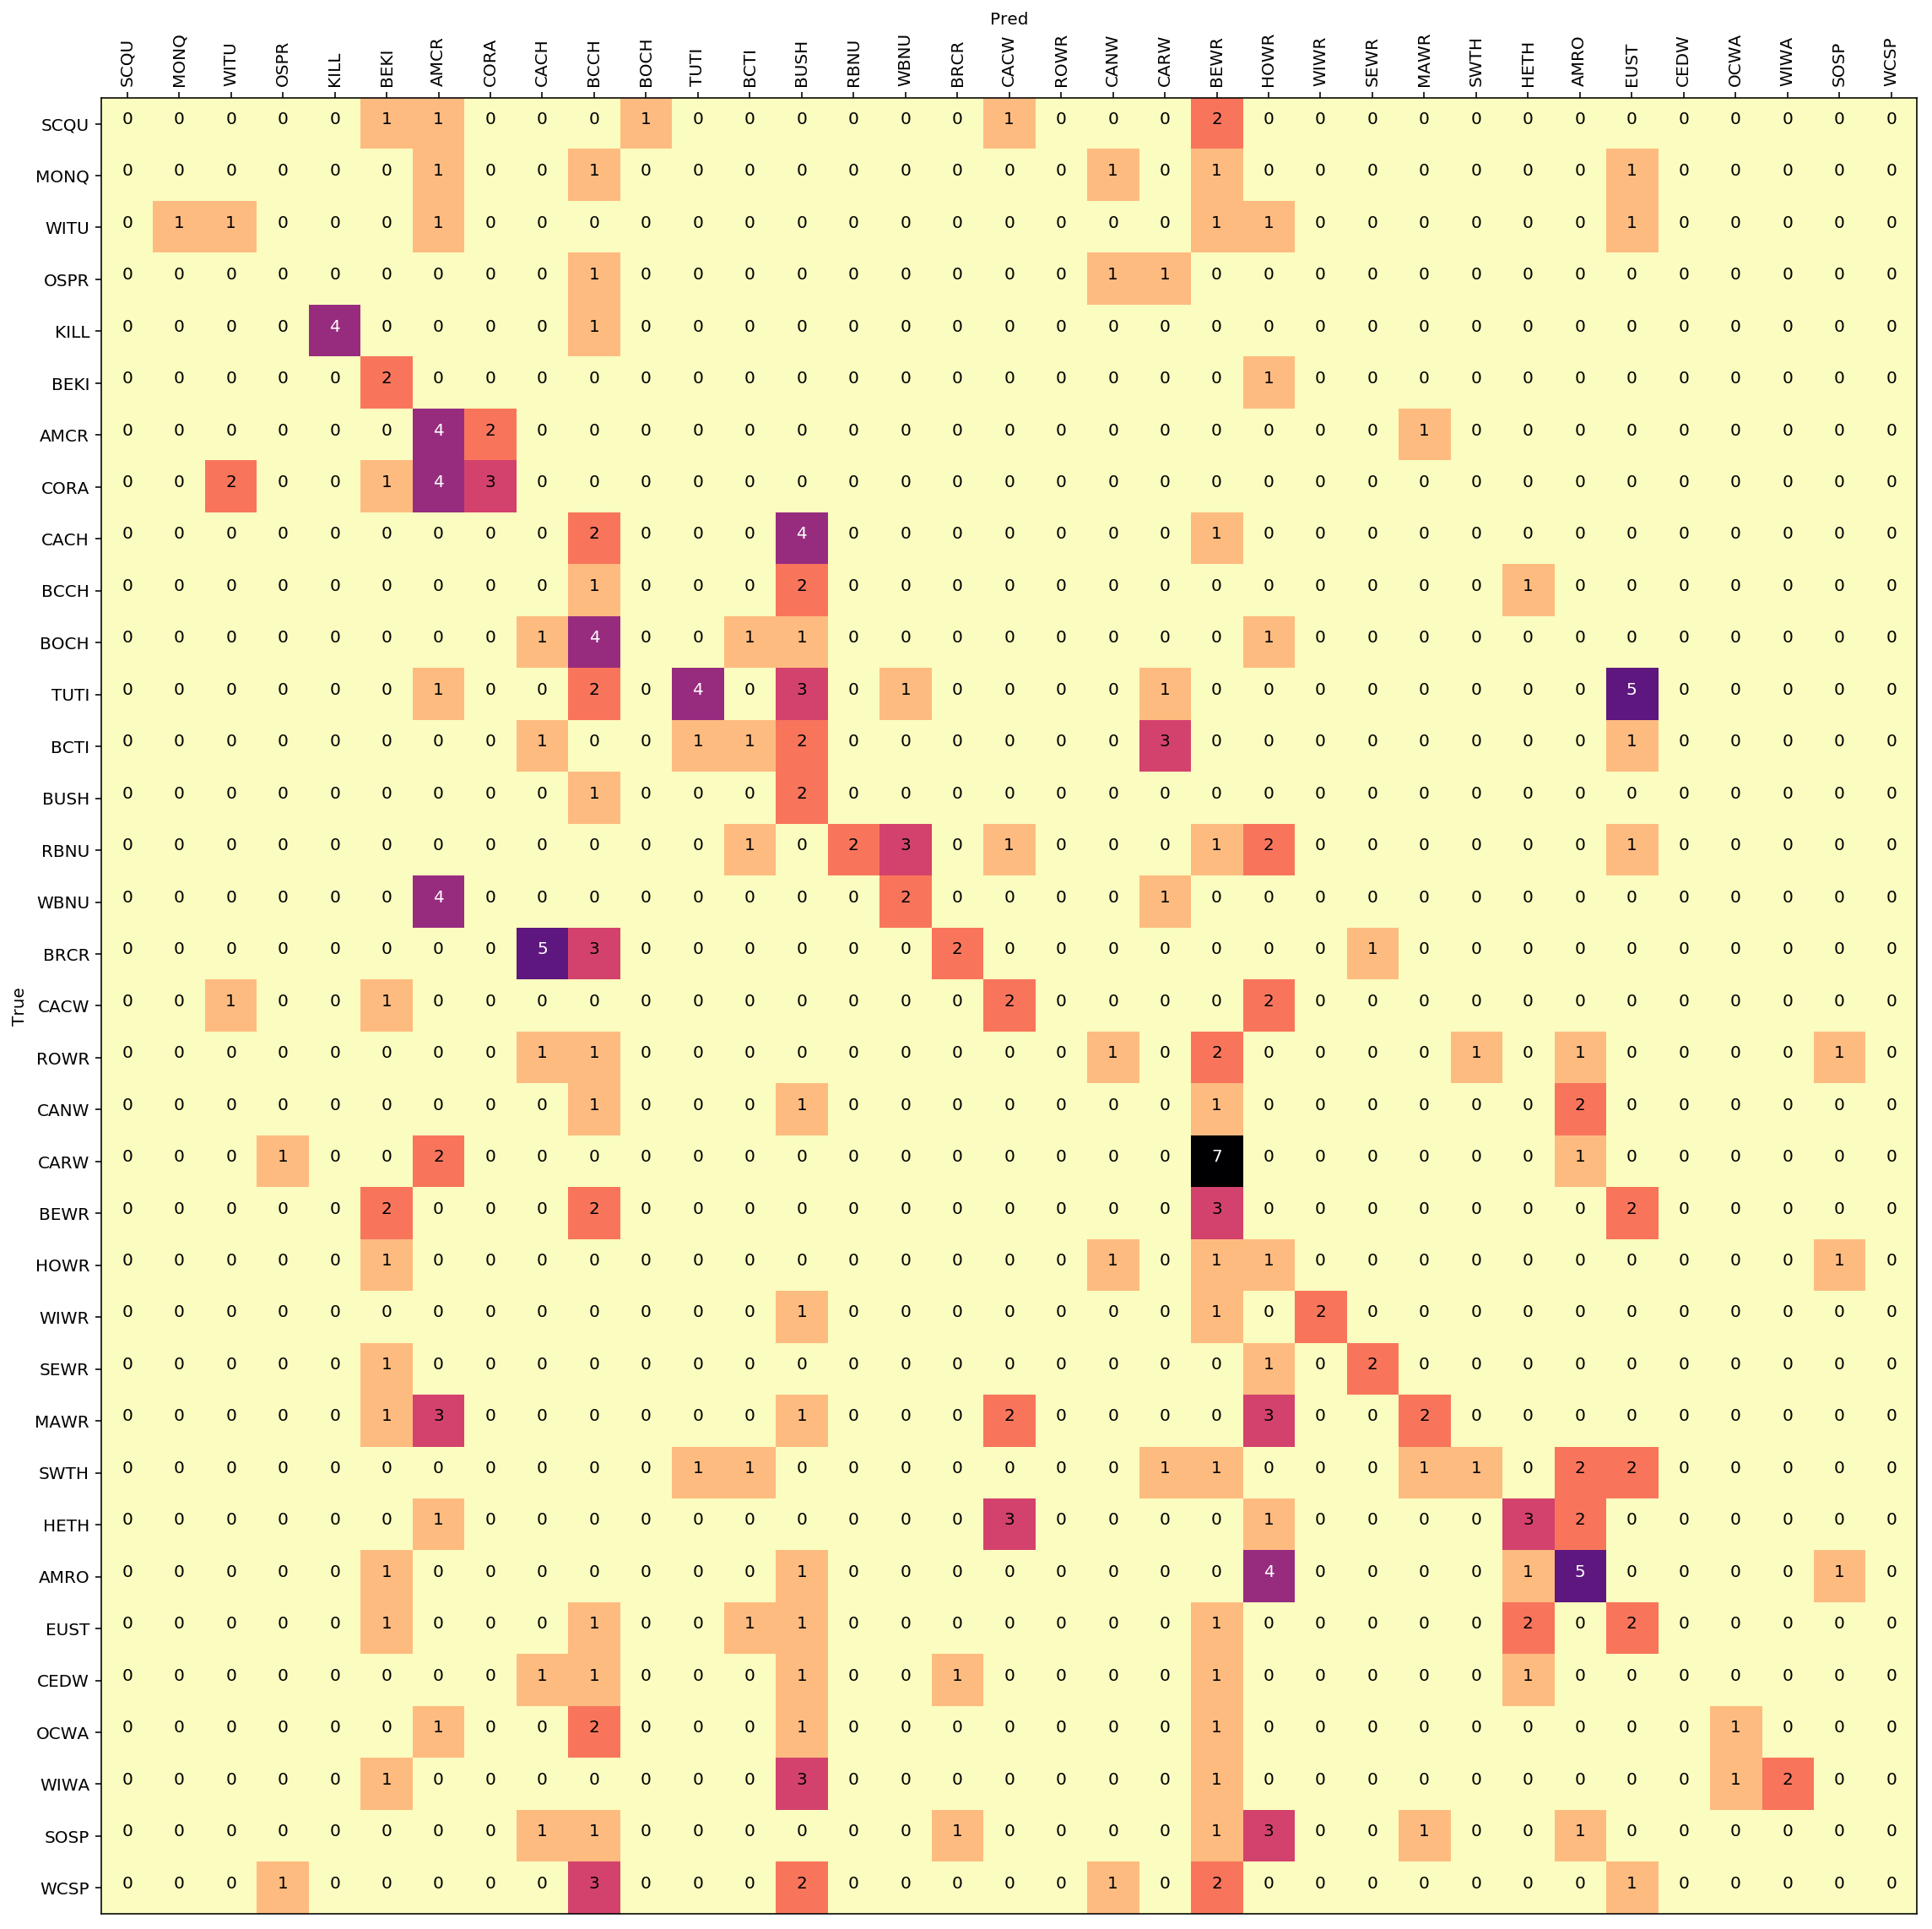

CPU times: user 5.56 s, sys: 504 ms, total: 6.06 s
Wall time: 5.47 s


In [ ]:
%%time
with with_figsize('full'):
    search.plot_confusion_matrix(recs_test)

In [ ]:
# Example usage
# search.species(recs_test[:5])
# search.species_probs(recs_test[:5]).T[:search.knn_.n_neighbors + 1].T
# search.similar_recs(recs_test[:5], 10)